In [1]:
import csv
import pandas as pd
import ast

from bisect import bisect
from scipy.stats.stats import pearsonr
from matplotlib import pyplot as plt

In [3]:
ctx30_valid_score = pd.read_csv("../data/evaluation/pred_gt_orders_30ctx.csv")
ctx40_valid_score = pd.read_csv("../data/evaluation/pred_gt_orders_40ctx.csv")

# 1. Kendall Tau Correlation Coefficient 분석

https://www.kaggle.com/code/cbeaud/ai4code-codebert-pairwise-score-0-8470

In [4]:
def count_inversions(a):
    inversions = 0
    sorted_so_far = []
    for i, u in enumerate(a):
        j = bisect(sorted_so_far, u)
        inversions += i - j
        sorted_so_far.insert(j, u)
    return inversions

In [5]:
def kendall_tau(ground_truth, predictions):
    total_inversions = 0
    total_2max = 0  # twice the maximum possible inversions across all instances
    
    for gt, pred in zip(ground_truth, predictions):
        ranks = [gt.index(x) for x in pred]  # rank predicted order in terms of ground truth
        total_inversions += count_inversions(ranks)
        n = len(gt)
        total_2max += n * (n - 1)

    return 1 - 4 * total_inversions / total_2max

## 1.1. 샘플 내 셀 개수와 Kendall Coefficient 간 상관 관계 분석

In [6]:
ctx30_valid_prediction, ctx30_valid_answer = ctx30_valid_score["cell_id"], ctx30_valid_score["cell_order"]
ctx40_valid_prediction, ctx40_valid_answer = ctx40_valid_score["cell_id"], ctx40_valid_score["cell_order"]

assert len(ctx30_valid_prediction) == len(ctx30_valid_answer)
assert len(ctx40_valid_prediction) == len(ctx40_valid_answer)

In [7]:
ctx30_valid_prediction, ctx30_valid_answer = [ast.literal_eval(pred) for pred in ctx30_valid_prediction], [ast.literal_eval(ans) for ans in ctx30_valid_answer]
ctx40_valid_prediction, ctx40_valid_answer = [ast.literal_eval(pred) for pred in ctx40_valid_prediction], [ast.literal_eval(ans) for ans in ctx40_valid_answer]

In [12]:
def draw_scatter_plot(answer_list, prediction_list):
    X_len = []
    Y_score = []

    for gt, pred in zip(answer_list, prediction_list):
        X_len.append(len(pred))
        Y_score.append(kendall_tau([gt], [pred]))
        
    print(f"pearsonr correlation is {pearsonr(X_len, Y_score)[0]}")

    plt.scatter(X_len, Y_score)
    plt.show()

    return Y_score

pearsonr correlation is -0.059662351031104385


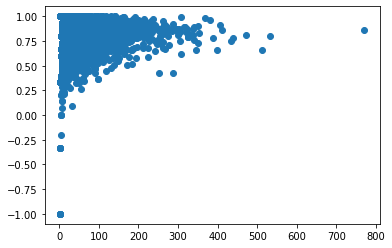

pearsonr correlation is -0.06055689257802984


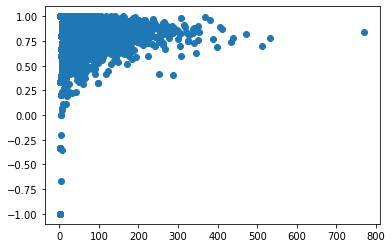

In [13]:
ctx30_kendall_coefficients = draw_scatter_plot(ctx30_valid_answer, ctx30_valid_prediction)
ctx40_kendall_coefficients = draw_scatter_plot(ctx40_valid_answer, ctx40_valid_prediction)

In [14]:
ctx30_valid_score["kendall"] = ctx30_kendall_coefficients
ctx40_valid_score["kendall"] = ctx40_kendall_coefficients

In [18]:
ctx30_valid_score.to_csv("../data/evaluation/pred_gt_orders_30ctx_w_kendall")
ctx40_valid_score.to_csv("../data/evaluation/pred_gt_orders_40ctx_w_kendall")

## 1.2. Kendall Tau Coefficient가 낮은 샘플들 정성적으로 확인

(-0.059662351031104385, 2.22362689399842e-12)